In [260]:
import pandas as pd

filename = '../big_a_data/all.csv'
df = pd.read_csv(filename, converters={'code': str})
#df = df[df['code'].isin(['000063', '002179', '002223', '600660', '600887', '601318'])]
df = df[~df['code'].str.startswith(('300', '688'))] #去掉创业板和科板
print('Done', len(df))
df.head(3)

Done 3837


,code,name,行业,上市时间,最新,涨幅,股息率_2023
0,000001,平安银行,银行,19910403,10.13,-0.1,7.1
1,000002,万科A,房地产开发,19910129,6.81,2.41,0.0
2,000004,国华网安,软件开发,19901201,10.12,1.81,0.0


In [261]:
str_today = '2024-07-30'
DURATION = 330
DAYS_PRE = 5
DAYS_NEXT = 5
DIE = 5
cols_pre = [f'd-{i}' for i in range(DAYS_PRE, 0, -1)]
cols_next = [f'd{i}' for i in range(1, DAYS_NEXT + 1)]
filename_output = f'跌买_前{DAYS_PRE}日_跌{DIE}买_后{DAYS_NEXT}日_涨跌统计_{str_today}.csv'
df_out = pd.DataFrame()
dict_code_x = {}

for code in df['code']:
    print(code, end='\r')
    df_process = pd.read_csv(f'../big_a_ds/process_daily/{code}.csv')
    if df_process.iloc[-1]['日期'] != str_today: continue #停牌票
    if len(df_process) < DURATION + DAYS_PRE + DAYS_NEXT + DAYS_NEXT: continue #不够数量
    
    df_select = df_process[-DURATION - DAYS_NEXT : -DAYS_NEXT]
    df_select = df_select[['日期'] + cols_pre + cols_next]
    df_select[f'前{DAYS_PRE}日最大跌幅'] = df_select[cols_pre].max(axis=1)
    df_select[f'后{DAYS_NEXT}日最大涨幅'] = df_select[cols_next].max(axis=1)
    df_select = df_select[['日期', f'前{DAYS_PRE}日最大跌幅', f'后{DAYS_NEXT}日最大涨幅']]   
    
    df_select = df_select[df_select[f'前{DAYS_PRE}日最大跌幅'] >= DIE]
    df_select = df_select[[f'后{DAYS_NEXT}日最大涨幅']]
    dict_code_x[code] = df_select[f'后{DAYS_NEXT}日最大涨幅']     
 
    df_stat = df_select.describe().transpose()
    df_stat['code'] = code
    
    df_hist = pd.read_csv(f'../big_a_data/hist_daily/{code}.csv')
    value_close = df_hist.iloc[-1]['收盘']
    value_max = max(df_hist[-5 : ]['最高'])
    rate = (value_max / value_close - 1) * 100
    if rate >= DIE:
        df_stat[str_today] = 'YES'
    else:
        df_stat[str_today] = 'NO'    
        
    df_out = pd.concat([df_out, df_stat], ignore_index=True)

df_out = pd.merge(df, df_out, on='code', how='inner')
print('\r\nDone', len(df_out))

920002
Done 3600


In [262]:
df_out.drop(['上市时间', '最新', '涨幅'], axis=1, inplace=True)
df_out.head(3)

,code,name,行业,股息率_2023,count,mean,std,min,25%,50%,75%,max,2024-07-30
0,000001,平安银行,银行,7.1,79.0,2.401266,2.577283,-0.43,0.5300,1.60,3.415,11.30,NO
1,000002,万科A,房地产开发,0.0,175.0,3.573257,4.568085,-2.09,0.8350,2.01,4.735,27.36,NO
2,000004,国华网安,软件开发,0.0,258.0,8.421705,8.230911,-4.35,2.2575,6.35,12.490,46.45,YES


In [263]:
df_out.sort_values(by = [str_today, 'min'],
                   ascending = False,
                   inplace = True)
df_out.to_csv(filename_output, index=False)

[Text(0.5, 1.0, 'Frequency Histogram 603393'), Text(0, 0.5, 'Frequency')]

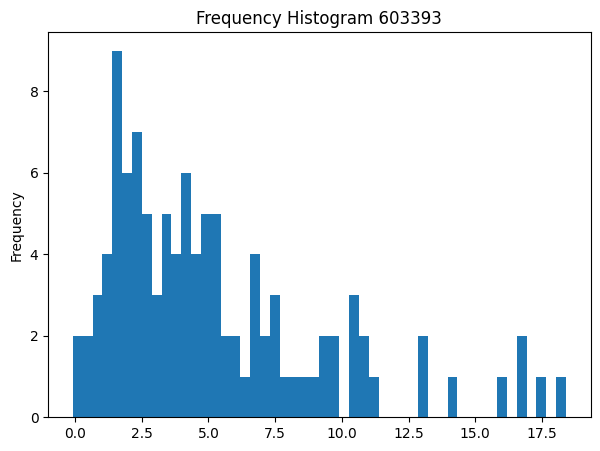

In [264]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

code = '603393' #新天燃气
x = dict_code_x[code]
plt.hist(x, bins=50)
plt.gca().set(title=f'Frequency Histogram {code}', ylabel='Frequency')